In [1]:
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#constantes
Kb = 8.6173324e-5

SIZE = 4
TEMPERATURAS = [i for i in np.arange(250,255.1,0.1)]

E_A = 0
E_B = 0
E_AA = -0.05
E_BB = -0.05
E_AB = -0.05

N_A = 1
N_B = (SIZE*SIZE) - N_A
E_on_site = N_A * E_A + N_B * E_B


TEMPERATURA = 300 #K
STEP = 1

In [3]:
def possible_matrices(size, N_a, N_b):
    """
    size: matrix order
    N_a: number of 'A's to be placed
    N_b: number of 'B's to be placed
    """
    
    # Check if the total number of elements matches the sum of N_a and N_b
    if N_a + N_b != size * size:
        raise ValueError("The total number of 'A's and 'B's should match the size of the matrix.")
    
    # If N_a is zero, directly create a matrix filled with 'B's
    if N_a == 0:
        return np.full((1, size, size), 'B', dtype='<U1')
    
    # Generate all possible combinations of indices for 'A's
    indices_A = np.array(list(itertools.combinations(range(size*size), N_a)))
    
    # Generate matrices with 'B's filled in all cells
    matrices = np.full((len(indices_A), size, size), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (size, size))
        matrices[i][indices] = 'A'
    
    #print(len(matrices))
    return matrices


In [165]:
def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    
    vizinhos = {}
    linhas, colunas = matriz.shape

    for i, j in itertools.product(range(linhas), range(colunas)):
        vizinhos[(i, j)] = []

        # Vizinhos à direita e abaixo
        det_vizinhos = lambda x, y: vizinhos[(i, j)].append(matriz[x, y])
        if j < colunas - 1: det_vizinhos(i, j + 1)
        if i < linhas - 1: det_vizinhos(i + 1, j)

        # Vizinhos nas bordas
        if j == 0: det_vizinhos(i, colunas - 1)
        if j == colunas - 1: det_vizinhos(i, 0)
        if i == 0: det_vizinhos(linhas - 1, j)
        if i == linhas - 1: det_vizinhos(0, j)

    return vizinhos


In [178]:
def energia_total(matriz, E_AB, E_AA, E_BB, E_on_site):
    """ Esta função calcula a energia de cada vizinho e a energia total da célula.
    
    Args:
        matriz: configuração da célula.
        E_AB: energias entre os elementos A e B.
        E_AA: energias entre os elementos A e A.
        E_BB: energias entre os elementos B e B.
        E_on_site: energia para o próprio sítio.
        
    Return:
        energia_célula: energia total da configuração da célula.
        energias_vizinhos: lista com os valores de energia entre cada vizinho.
    """
    vizinhos_dict = determinar_vizinhos(matriz)
    energias_vizinhos = np.array([])

    for coordenada, vizinhos in vizinhos_dict.items():
        i, j = coordenada
        elemento = matriz[i, j]
        vizinhos = np.array(vizinhos)

        # Energia entre o elemento e seus vizinhos
        energia_elemento_vizinhos = np.where(elemento != vizinhos, E_AB, 
                                              np.where(elemento == 'A', E_AA, E_BB))
        energias_vizinhos = np.concatenate((energias_vizinhos, energia_elemento_vizinhos))

    energia_célula = np.sum(energias_vizinhos) + E_on_site
    return energia_célula

In [6]:
def helmholtz(energias, temperatura):
    """Essa função calcula o valor da função de partição
    
    Args:
        
        energias: lista com a energia de cada configuração da célula.
        temperatura: temperatura na qual estaria a célula.
        
    Return:
    
        Z: valor da função de partição em uma temperatura.
    """
    beta = 1.0 / (Kb * temperatura)
    Z = 0.0
    for energia in energias:
        Z += np.exp(-beta * energia)

    F = beta * np.log(Z)
    
    return F

In [66]:
TEMPERATURA = 250
SIZE = 4
STEP = 1

E_A = 0
E_B = 0
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3

In [67]:
size = SIZE
step = STEP
print(STEP)

N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
print(N_A_range)
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)


1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]
[ 0.          0.06666667  0.14285714  0.23076923  0.33333333  0.45454545
  0.6         0.77777778  1.          1.28571429  1.66666667  2.2
  3.          4.33333333  7.         15.          1.        ]


C:\Users\gustavo220061\AppData\Local\Temp\ipykernel_23296\2932245074.py:8: RuntimeWarning: divide by zero encountered in divide
  N_A_B_ratio = N_A_range / N_B_range


In [68]:
def analise(size, N_a, N_b, temperaturas):
    energia_matrix_list = []
    energia_helmholtz_list = []

    for N_a in N_A_range:
        energia_matrix_list = []
        print('concen',N_a,N_b)
        N_b = size*size - N_a
        matrices = possible_matrices(size,N_a,N_b)

        for matrix in matrices:
            vizinhos = determinar_vizinhos(matrix)
            energia_matrix = energia_total(matrix, E_AB, E_AA, E_BB, E_on_site)
            energia_matrix_list.append(energia_matrix)
        #print(energia_matrix_list)

        for T in temperaturas:
            energia_helmholtz = helmholtz(energia_matrix_list,T)
            print(energia_helmholtz)
            energia_helmholtz_list.append(energia_helmholtz)

    #data = pd.DataFrame({"Temperatura": temperaturas, "Energia de Helmholtz": energia_helmholtz_list, "N_a" : N_a, "N_b" : N_b})
    return energia_helmholtz_list

In [69]:
analise(SIZE,N_A,N_B,[TEMPERATURA])

concen 0 0
17237.103075741274
concen 1 16
18595.125602890494
concen 2 15
19859.994330201684
concen 3 14
20999.37722568787
concen 4 13
22094.444874719724
concen 5 12
23152.93044062992
concen 6 11
24167.607734340905
concen 7 10
25059.039256293585
concen 8 9
25887.829172901744
concen 9 8
24196.30205189988
concen 10 7
22440.44305970117
concen 11 6
20350.1370880322
concen 12 5
18214.32012928302
concen 13 4
16040.872100423176
concen 14 3
13821.908764362546
concen 15 2
11268.474745093801
concen 16 1
8618.551537870637


[17237.103075741274,
 18595.125602890494,
 19859.994330201684,
 20999.37722568787,
 22094.444874719724,
 23152.93044062992,
 24167.607734340905,
 25059.039256293585,
 25887.829172901744,
 24196.30205189988,
 22440.44305970117,
 20350.1370880322,
 18214.32012928302,
 16040.872100423176,
 13821.908764362546,
 11268.474745093801,
 8618.551537870637]

In [72]:
en = [17237.103075741274,
 18595.125602890494,
 19859.994330201684,
 20999.37722568787,
 22094.444874719724,
 23152.93044062992,
 24167.607734340905,
 25059.039256293585,
 25887.829172901744,
 24196.30205189988,
 22440.44305970117,
 20350.1370880322,
 18214.32012928302,
 16040.872100423176,
 13821.908764362546,
 11268.474745093801,
 8618.551537870637]

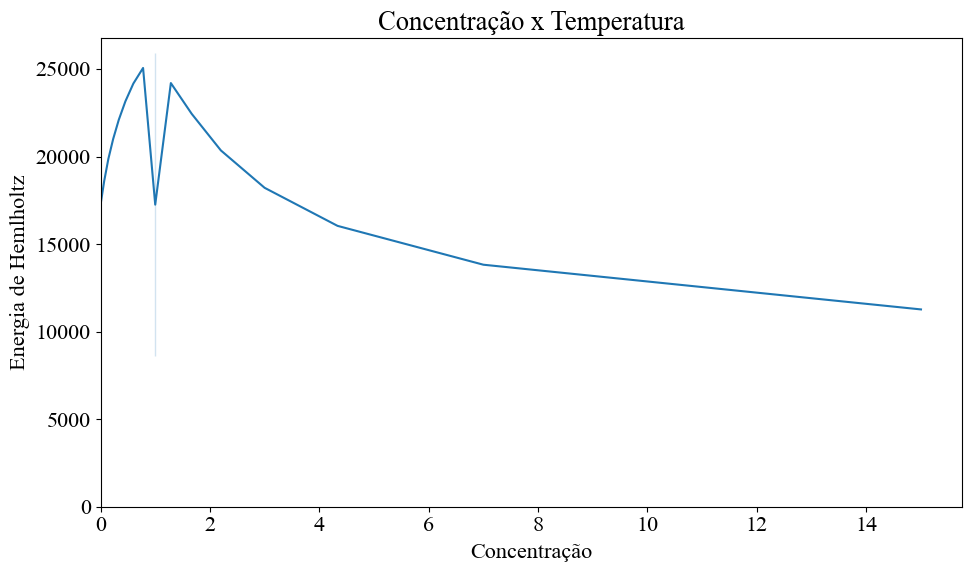

In [73]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.lineplot(x=N_A_B_ratio, y=en)
plt.xlim(0, None)
plt.ylim(0, None)
sns.color_palette("Paired")
plt.title('Concentração x Temperatura')
plt.xlabel('Concentração')
plt.ylabel('Energia de Hemlholtz')
plt.tight_layout()
# fig.get_figure() #'pega' o gráfico para salvar
# fig.savefig("helmholtz.pdf") #salva o gráfico 

### Playground

In [41]:
E_A = 0
E_B = 0
E_AA = -0.1
E_BB = -0.2
E_AB = -0.3

In [42]:
temperaturas = [250]
n=3
E_on_site = N_A * E_A + N_B * E_B

In [43]:
def Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas):
    """Essa função realiza toda a análise de caso
    
    Args:
        N_A: número de átomos A.
        N_B: número de átomos B.
        n: ordem da célula quadrada.
        E_AB: energia entre A e B.
        E_AA: energia entre A e A.
        E_BB: energia entre B e B.
        temperatura: intervalo de temperatura em que analisaremos a célula.
        
    Return:
    
        data: dataframe com as informações de temperatura e energia livre de helmholtz.
    """
    energias = []
    lista_helm = []
    células = possible_matrices(n,N_A, N_B)
    
    for cell in células:
        energia_célula = energia_total(cell, E_AB, E_AA, E_BB,E_on_site)
        energias.append(energia_célula)
    
    for T in temperaturas:
        F = helmholtz(energias, T)
        lista_helm.append(F)
    
    data = pd.DataFrame({"Temperatura": temperaturas, "F": lista_helm})
    return data

In [44]:
# Definição dos casos

N_A = 0
N_B = 9
E_on_site = N_A * E_A + N_B * E_B
meu_caso0 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso0)

N_A = 1
N_B = 8
E_on_site = N_A * E_A + N_B * E_B
meu_caso1 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso1)

N_A = 2
N_B = 7
E_on_site = N_A * E_A + N_B * E_B
meu_caso2 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso2)

N_A = 3
N_B = 6
E_on_site = N_A * E_A + N_B * E_B
meu_caso3 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso3)
N_A = 4
N_B = 5
E_on_site = N_A * E_A + N_B * E_B
meu_caso4 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso4)

N_A = 5
N_B = 4
E_on_site = N_A * E_A + N_B * E_B
meu_caso5 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso5)

N_A = 6
N_B = 3
E_on_site = N_A * E_A + N_B * E_B
meu_caso6 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso6)

N_A = 7
N_B = 2
E_on_site = N_A * E_A + N_B * E_B
meu_caso7 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso7)

N_A = 8
N_B = 1
E_on_site = N_A * E_A + N_B * E_B
meu_caso8 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso8)

N_A = 9
N_B = 0
E_on_site = N_A * E_A + N_B * E_B
meu_caso9 = Análise(N_A, N_B, n, E_AB, E_AA, E_BB, temperaturas)
print(meu_caso9)

   Temperatura             F
0          250  10342.261845
   Temperatura             F
0          250  11699.840102
   Temperatura             F
0          250  12961.774759
   Temperatura             F
0          250  13872.858297
   Temperatura             F
0          250  13886.653655
   Temperatura             F
0          250  13455.282917
   Temperatura             F
0          250  12149.735078
   Temperatura             F
0          250  10374.453659
   Temperatura            F
0          250  7821.049816
   Temperatura            F
0          250  5171.130923


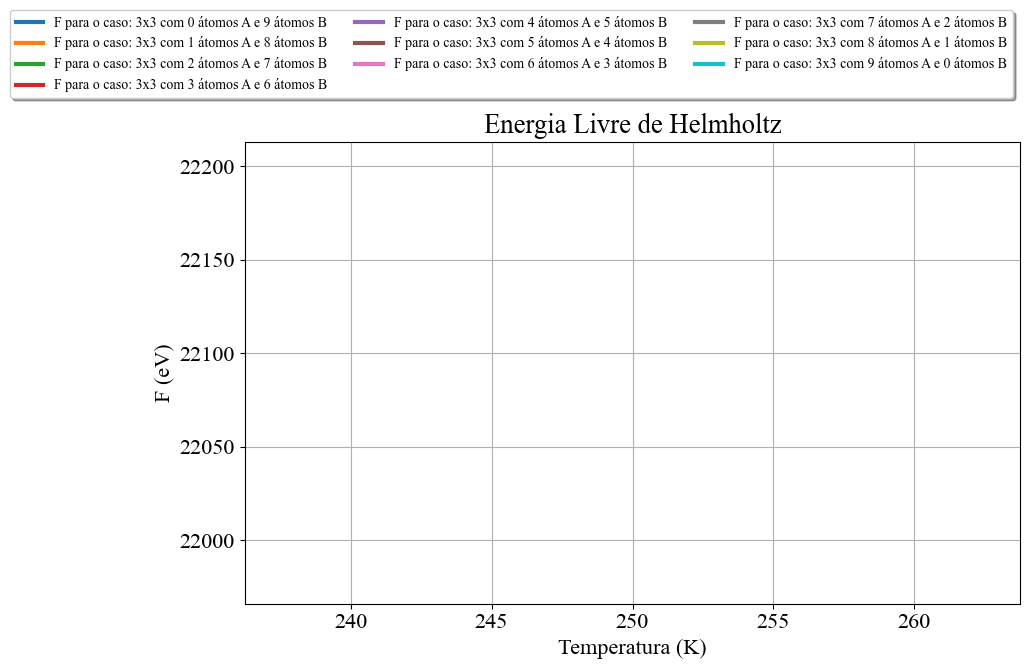

In [40]:
# Crie uma figura
plt.figure(figsize=(10, 6))  # Tamanho da figura

plt.rcParams.update({
    'font.family': "Times New Roman",
    'font.size': 16,  # Tamanho da fonte
    'legend.fontsize': 10,  # Tamanho da fonte na legenda
    'xtick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo x
    'ytick.labelsize': 16,  # Tamanho da fonte nos rótulos do eixo y
})

# Plote cada conjunto de dados com uma cor diferente e rótulos grandes

plt.plot(meu_caso0["Temperatura"], meu_caso0["F"], label=f"F para o caso: {n}x{n} com {0} átomos A e {9} átomos B", linewidth=3)
plt.plot(meu_caso1["Temperatura"], meu_caso1["F"], label=f"F para o caso: {n}x{n} com {1} átomos A e {8} átomos B", linewidth=3)
plt.plot(meu_caso2["Temperatura"], meu_caso2["F"], label=f"F para o caso: {n}x{n} com {2} átomos A e {7} átomos B", linewidth=3)
plt.plot(meu_caso3["Temperatura"], meu_caso3["F"], label=f"F para o caso: {n}x{n} com {3} átomos A e {6} átomos B", linewidth=3)
plt.plot(meu_caso4["Temperatura"], meu_caso4["F"], label=f"F para o caso: {n}x{n} com {4} átomos A e {5} átomos B", linewidth=3)
plt.plot(meu_caso5["Temperatura"], meu_caso5["F"], label=f"F para o caso: {n}x{n} com {5} átomos A e {4} átomos B", linewidth=3)
plt.plot(meu_caso6["Temperatura"], meu_caso6["F"], label=f"F para o caso: {n}x{n} com {6} átomos A e {3} átomos B", linewidth=3)
plt.plot(meu_caso7["Temperatura"], meu_caso7["F"], label=f"F para o caso: {n}x{n} com {7} átomos A e {2} átomos B", linewidth=3)
plt.plot(meu_caso8["Temperatura"], meu_caso8["F"], label=f"F para o caso: {n}x{n} com {8} átomos A e {1} átomos B", linewidth=3)
plt.plot(meu_caso9["Temperatura"], meu_caso9["F"], label=f"F para o caso: {n}x{n} com {9} átomos A e {0} átomos B", linewidth=3)

# Adicione um título e rótulos de eixos
plt.title('Energia Livre de Helmholtz')
plt.xlabel('Temperatura (K)')
plt.ylabel('F (eV)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 1.3), ncol=3, fancybox=True, shadow=True)
plt.grid()

# Exiba o gráfico
plt.show()

In [ ]:
def analise(size, N_a_range, temperatura):
    energia_matrix_list = []
    energia_helmholtz_list = []
    energia_config = []
    
    for N_a in N_a_range:
        print(N_a)
        N_b = (size*size) - N_a
        matrices = possible_matrices(size,N_a,N_b)
        for matrix in matrices:
            #vizinhos = determinar_vizinhos(matrix)
            energia_matrix = energia_total(matrix, E_AB, E_AA, E_BB, E_on_site)
            energia_matrix_list.append(energia_matrix)
        energia_helmholtz = helmholtz(energia_matrix_list,temperatura)
        energia_helmholtz_list.append(energia_helmholtz)
        energia_config.append(sum(energia_helmholtz_list))
        energia_matrix_list = []
        energia_helmholtz_list = []

    print(energia_config)


    return energia_config, len(energia_config)

In [ ]:
N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)

In [ ]:
size = SIZE
step = STEP
print(STEP)

N_A_range = np.array([n for n in np.arange(0,size*size+step,step)]) # 1 A size**2
print(N_A_range)
N_B_range = N_A_range[::-1]
N_A_B_ratio = N_A_range / N_B_range
N_A_B_ratio = np.where(np.isinf(N_A_B_ratio), 1, N_A_B_ratio)
print(N_A_B_ratio)


1
[0 1 2 3 4 5 6 7 8 9]
[0.         0.125      0.28571429 0.5        0.8        1.25
 2.         3.5        8.         1.        ]


C:\Users\gustavo220061\AppData\Local\Temp\ipykernel_21928\2932245074.py:8: RuntimeWarning: divide by zero encountered in divide
  N_A_B_ratio = N_A_range / N_B_range


In [ ]:
lst = [-10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2, -10.2]
helmholtz(lst, 270.1)

18947.169590983623

In [ ]:
def calcular_vizinhos_v1(matriz):
    linhas, colunas = matriz.shape
    vizinhos = {}

    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    indices = itertools.product(range(linhas), range(colunas))

    for i, j in indices:
        vizinhos[(i, j)] = []

        # Calculate indices of neighboring elements
        neighbor_indices = (np.array([i, j]) + offsets) % np.array([linhas, colunas])

        # Add neighbors to the current element
        for ni, nj in neighbor_indices:
            vizinhos[(i, j)].append(matriz[ni, nj])

    return vizinhos

# Example usage
matriz = np.array([[1, 2, 3],
                   [4, 5, 6],
                   [7, 8, 9]])
vizinhos = calcular_vizinhos_v1(matriz)
print(vizinhos)


{(0, 0): [2, 4, 3, 7], (0, 1): [3, 5, 1, 8], (0, 2): [1, 6, 2, 9], (1, 0): [5, 7, 6, 1], (1, 1): [6, 8, 4, 2], (1, 2): [4, 9, 5, 3], (2, 0): [8, 1, 9, 4], (2, 1): [9, 2, 7, 5], (2, 2): [7, 3, 8, 6]}


In [ ]:
import numpy as np

def determinar_vizinhos_v2(matrix, size):
    # Array of offsets for neighboring elements
    offsets = np.array([[0, 1], [1, 0], [0, -1], [-1, 0]])

    # Generate indices for all elements in the matrix
    i, j = np.indices((size, size))

    # Reshape offsets to have an extra dimension for broadcasting
    reshaped_offsets = offsets.reshape(1, 1, -1, 2)

    # Calculate indices of neighboring elements
    neighbor_indices = (i[..., np.newaxis, np.newaxis] + reshaped_offsets) % np.array([size, size])

    # Create a dictionary to store neighbors
    vizinhos = {(x, y): [matrix[neighbor_indices[x, y, k, 0]][neighbor_indices[x, y, k, 1]] for k in range(neighbor_indices.shape[2])] for x in range(size) for y in range(size)}

    return vizinhos

matriz_teste = [['AA', 'AB', 'BB'], ['AB', 'BB', 'BB'], ['BB', 'BB', 'BB']]
determiar_vizinho = determinar_vizinhos_v2(matriz_teste, 3)
print(determiar_vizinho)


{(0, 0): ['AB', 'AB', 'BB', 'BB'], (0, 1): ['AB', 'AB', 'BB', 'BB'], (0, 2): ['AB', 'AB', 'BB', 'BB'], (1, 0): ['BB', 'BB', 'AB', 'AB'], (1, 1): ['BB', 'BB', 'AB', 'AB'], (1, 2): ['BB', 'BB', 'AB', 'AB'], (2, 0): ['BB', 'BB', 'BB', 'BB'], (2, 1): ['BB', 'BB', 'BB', 'BB'], (2, 2): ['BB', 'BB', 'BB', 'BB']}


In [ ]:
import numpy as np
import itertools

def possible_matrices(N_A, N_B, n):
    total = N_A + N_B
    
    # Generate all possible combinations of indices for 'A's
    all_indices_A = list(itertools.combinations(range(n*n), N_A))
    
    # Generate matrices with 'B's filled in all cells
    matrices_B = np.full((len(all_indices_A), n, n), 'B', dtype='<U1')
    
    # Iterate through all possible combinations of indices for 'A's
    for i, indices in enumerate(all_indices_A):
        # Fill 'A's at specified indices
        indices = np.unravel_index(indices, (n, n))
        matrices_B[i][indices] = 'A'
    
    print(len(matrices_B))
    return matrices_B

# Example usage:
N_A = 3
N_B = 6
n = 3
result = possible_matrices(N_A, N_B, n)

# Printing the matrices
for matrix in result:
    print(matrix)
    print()


84
[['A' 'A' 'A']
 ['B' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['A' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'A' 'B']
 ['B' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'A']
 ['A' 'B' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 'A']
 ['B' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'B']
 ['A' 'A' 'B']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 'B']
 ['A' 'B' 'B']
 ['B' 'B' 'A']]

[['A' 'B' 'B']
 ['B' 'A' 'A']
 ['B' 'B' 'B']]

[['A' 'B' 'B']
 ['B' 'A' 'B']
 ['A' 'B' 'B']]

[['A' 'B' 'B']
 ['B' 'A' 'B']
 ['B' 'A' 'B']]

[['A' 'B' 

In [ ]:
import itertools

def determinar_vizinhos(matriz):
    """ Essa função fornece um dicionário que relaciona todos os elementos na célula
    a seus vizinhos, tanto os de dentro da célula quanto os de células vizinhas iguais.
    
    Args:
    
        matriz: a célula da qual queremos saber os elementos e seus vizinhos
        
    Return:
    
        vizinhos: um dicionário com as chaves sendo as coordenadas da matriz e os valores os vizinhos dessa coordenada"""
    vizinhos = {}
    linhas, colunas = len(matriz), len(matriz[0])

    for i, j in itertools.product(range(linhas), range(colunas)):
        vizinhos[(i, j)] = []

        # Vizinhos à direita e abaixo
        append_neighbor = lambda x, y: vizinhos[(i, j)].append(matriz[x][y])
        if j < colunas - 1: append_neighbor(i, j + 1)
        if i < linhas - 1: append_neighbor(i + 1, j)

        # Vizinhos nas bordas
        if j == 0: append_neighbor(i, colunas - 1)
        if j == colunas - 1: append_neighbor(i, 0)
        if i == 0: append_neighbor(linhas - 1, j)
        if i == linhas - 1: append_neighbor(0, j)

    return vizinhos
